---

# Modèles de Machine Learning

---

##### Implémentation de différents modèles de machine learning appliqués à la prédiction de données sur les données de consommation électrique.

## Import des librairies nécessaires, initialisation et mise en forme du set de données.

##### On importe les différentes librairies Python nécessaires : Pandas / Numpy / Seaborn / XGBoost.

In [1]:
#importation des librairies nécéssaires
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error,average_precision_score
import matplotlib.pyplot as plt

dataset = pd.read_csv('AEP_hourly.csv')
dataset = dataset.set_index('Datetime')
dataset.index = pd.to_datetime(dataset.index)

In [2]:
#info du dataset
dataset.info()
dataset.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


(121273, 1)

##### On met en forme de set de données sur lequel nous travaillons.

In [3]:
#comptage du nombre de données manquantes dans le dataset
dataset.isnull().sum()

AEP_MW    0
dtype: int64

In [4]:
#résumé statistique
dataset.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [5]:
dataset = dataset.sort_values(by="Datetime")

<AxesSubplot:title={'center':'Energy use in MW'}, xlabel='Datetime'>

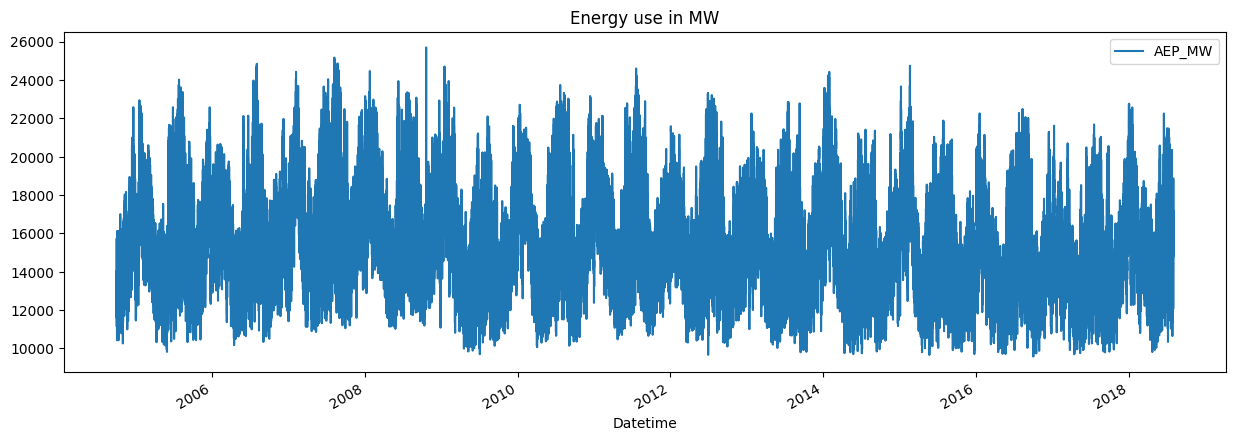

In [6]:
# plot des données 
dataset.plot(figsize=(15,5),title='Energy use in MW')

## Séparation du set de données.

##### Le set de données est séparé en 2 parties, l'une appelée "**Train**" contenant 80 % des données du set et l'autre appelée "**Test**".

In [7]:
#split train et test
nb_lines = dataset.shape[0]
train = dataset.iloc[:int(nb_lines*0.8)]
test = dataset.iloc[int(nb_lines*0.8)+1:]

<AxesSubplot:title={'center':'Energy use in MW'}, xlabel='Datetime'>

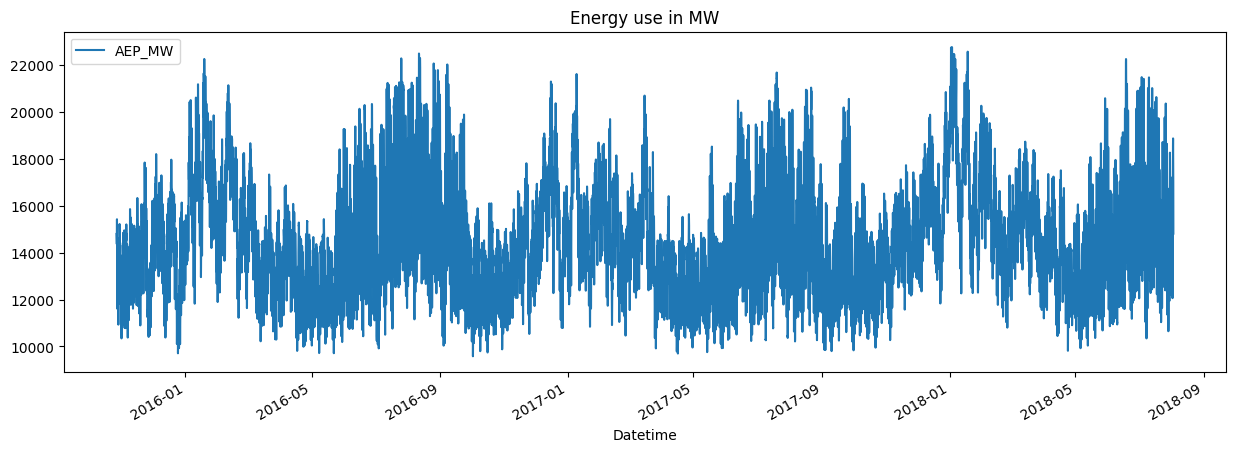

In [8]:
test.plot(figsize=(15,5),title='Energy use in MW')

##### Création d'une fonction qui explicite l'heure, le jour, la semaine, le mois et l'année pour chaque données présente dans notre set de données.

In [9]:
def creation_index_temps(ds):
    ds['Heure']=ds.index.hour
    ds['Jour(Semaine)']=ds.index.dayofweek
    ds['Semaine']=ds.index.week
    ds['Mois']=ds.index.month
    ds['Année']=ds.index.year
    ds['Jour(Année)']=ds.index.day
    return ds

ds = creation_index_temps(dataset)

/tmp/ipykernel_33255/3953485566.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  ds['Semaine']=ds.index.week


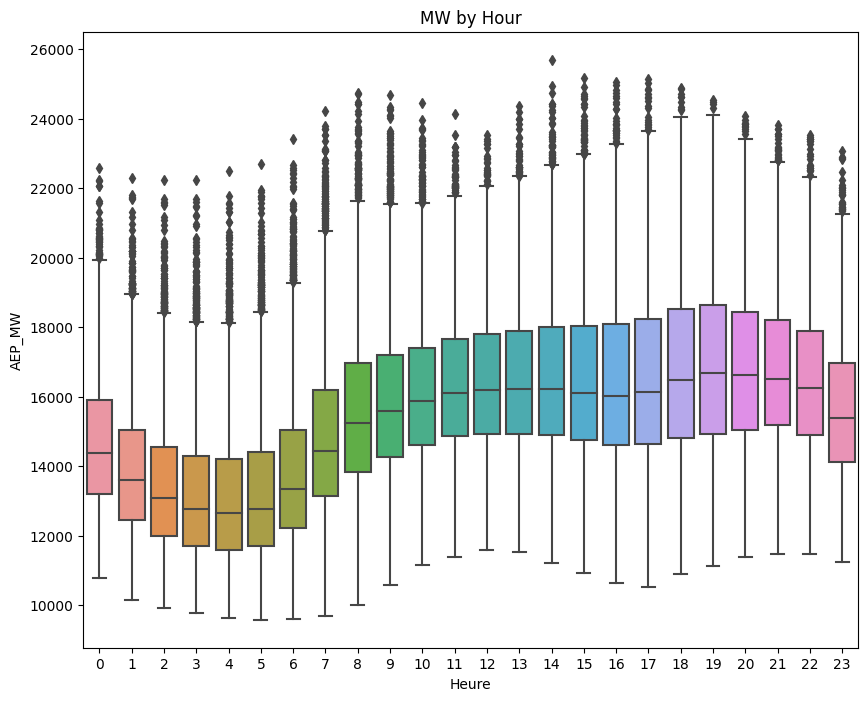

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=ds, x='Heure', y='AEP_MW')
ax.set_title('MW par heure')
plt.show()

In [11]:
creation_index_temps(dataset)

/tmp/ipykernel_33255/3953485566.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  ds['Semaine']=ds.index.week


,AEP_MW,Heure,Jour(Semaine),Semaine,Mois,Année,Jour(Année)
Datetime,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,40,10,2004,1
2004-10-01 02:00:00,11935.0,2,4,40,10,2004,1
2004-10-01 03:00:00,11692.0,3,4,40,10,2004,1
2004-10-01 04:00:00,11597.0,4,4,40,10,2004,1
2004-10-01 05:00:00,11681.0,5,4,40,10,2004,1
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,31,8,2018,2
2018-08-02 21:00:00,17303.0,21,3,31,8,2018,2
2018-08-02 22:00:00,17001.0,22,3,31,8,2018,2


In [12]:
train = creation_index_temps(train)
test = creation_index_temps(test)

/tmp/ipykernel_33255/3953485566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['Heure']=ds.index.hour
/tmp/ipykernel_33255/3953485566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds['Jour(Semaine)']=ds.index.dayofweek
/tmp/ipykernel_33255/3953485566.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(id

## Entraînement sur le set de données "**Train**".

##### On liste toutes les entrées sur lesquelles nous allons appliquer l'algorithme d'entraînement, ainsi que la sortie souhaitée (la valeur que nous souhaitons prédire avec le modèle).

In [13]:
ENTREES = ['Heure', 'Jour(Semaine)', 'Semaine', 'Mois', 'Année', 'Jour(Année)']
SORTIE = ['AEP_MW']

In [14]:
X_train = train[ENTREES]
Y_train = train[SORTIE]

X_test = test[ENTREES]
Y_test = test[SORTIE]

##### On entraîne le modèle de machine learning sur le set de données "**Train**" en utilisant la méthode de boosting de gradient extrême (XGBoost).

In [15]:
reg = xgb.XGBRegressor(
    n_estimators=100000,        # Hauteur maximale de l'arbre de décision créé lors du boosting
    early_stopping_rounds=100,  # Nombre maximal de sorties de la fonction
    learning_rate=0.0001)       # Ratio d'apprentissage
reg.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train),(X_test,Y_test)],
    verbose=1000)               # Pas d'affichage des sorties (ici toutes les 100 itérations)

[0]	validation_0-rmse:15905.62657	validation_1-rmse:14915.45600
[1000]	validation_0-rmse:14408.21706	validation_1-rmse:13421.35247
[2000]	validation_0-rmse:13054.74408	validation_1-rmse:12071.99231
[3000]	validation_0-rmse:11831.66248	validation_1-rmse:10857.12886
[4000]	validation_0-rmse:10726.92948	validation_1-rmse:9772.66067
[5000]	validation_0-rmse:9729.11530	validation_1-rmse:8794.73497
[6000]	validation_0-rmse:8827.91104	validation_1-rmse:7910.22430
[7000]	validation_0-rmse:8013.82637	validation_1-rmse:7123.05729
[8000]	validation_0-rmse:7279.62662	validation_1-rmse:6419.58070
[9000]	validation_0-rmse:6617.25072	validation_1-rmse:5787.64806
[10000]	validation_0-rmse:6020.01896	validation_1-rmse:5218.39694
[11000]	validation_0-rmse:5482.04142	validation_1-rmse:4709.61984
[12000]	validation_0-rmse:4997.93892	validation_1-rmse:4256.25822
[13000]	validation_0-rmse:4562.79783	validation_1-rmse:3855.06255
[14000]	validation_0-rmse:4172.04058	validation_1-rmse:3500.29853
[15000]	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

    L'algorithme s'exécute de manière à faire diminuer l'erreur "root-mean-squared-error" ou "rmse" sur le set de données d'entraînement, ce qui la fait parrallèlement diminuer pour le set de test (les données que nous souhaitons prédire). L'algorithme entraîne le modèle jusqu'à ce que l'erreur calculée sur le set de test soit minimale, en effet celle-ci augmente quand le modèle apprend par coeur les données sur lesquelles il s'est entraîné (cela s'appelle l'overfitting et ce n'est pas souhaitable pour les prédictions sur des nouveaux sets de données).

##### On trie dans l'ordre décroissant les paramètres pris en entrée selon leur utilisation et leur importance dans l'entraînement du modèle.

<AxesSubplot:title={'center':'Importance des facteurs utilisés dans le modèle'}>

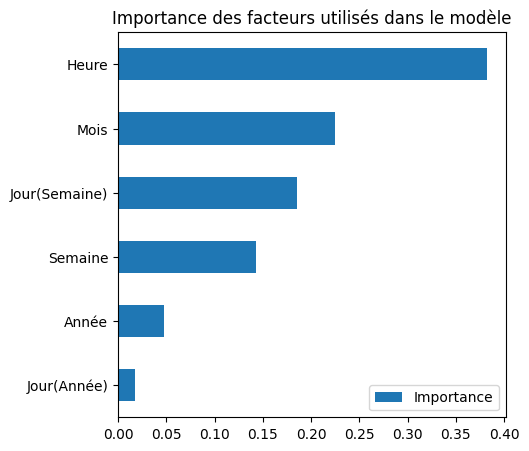

In [16]:
imp = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['Importance'])

imp.sort_values('Importance').plot(
    figsize=(5,5),
    kind='barh',
    title='Importance des facteurs utilisés dans le modèle')

##### On trace les données présentes dans le set de données "**Test**" ainsi que les prédictions estimées par le modèle.

/tmp/ipykernel_33255/2908521693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


Text(0.5, 1.0, 'Prédictions et données brutes')

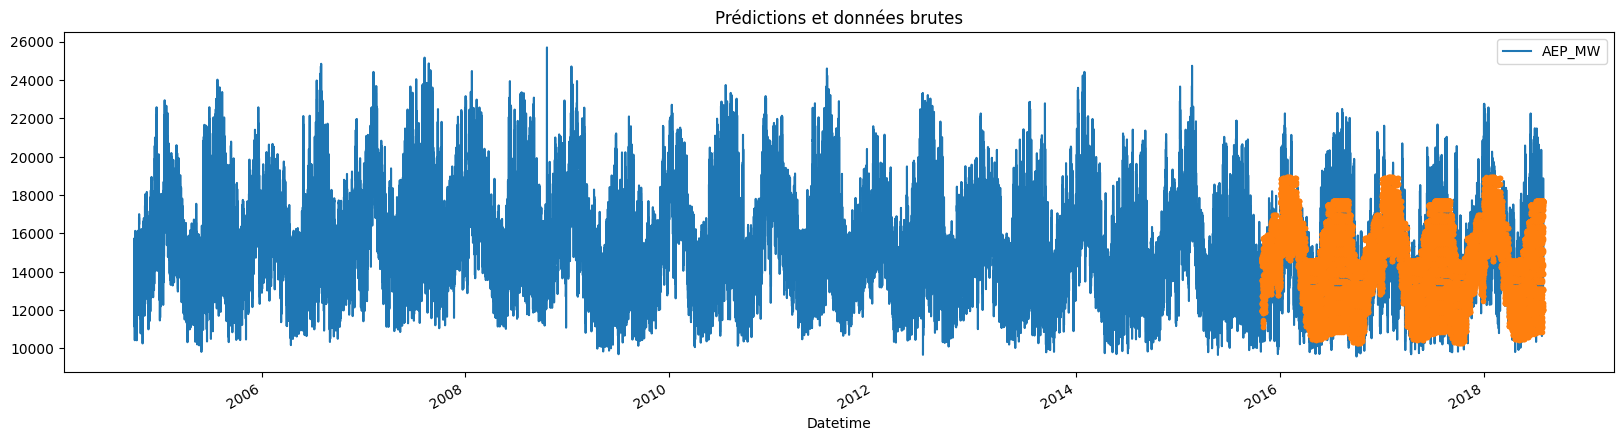

In [17]:
test['prediction'] = reg.predict(X_test)
dataset = dataset.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = dataset[['AEP_MW']].plot(figsize=(20,5))
dataset['prediction'].plot(ax=ax,style='.')
ax.set_title('Prédictions et données brutes')

    Intégralité des données prédites.

In [18]:
test_predic = dataset.iloc[int(nb_lines*0.8)+1:]

<AxesSubplot:xlabel='Datetime'>

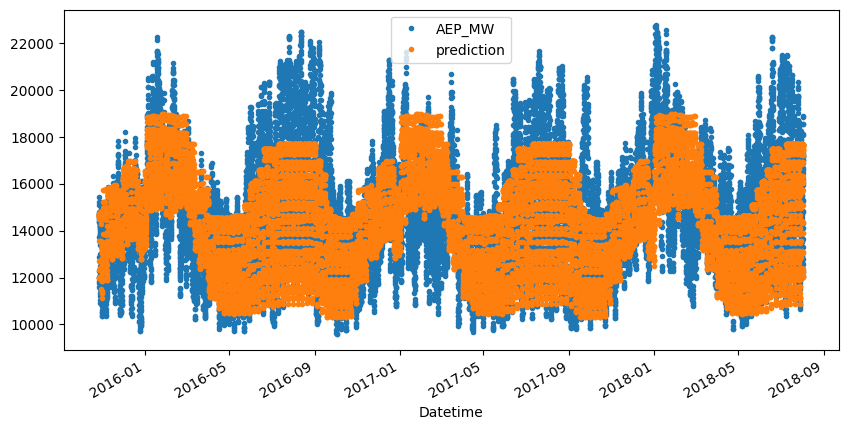

In [19]:
test_predic.plot(y=['AEP_MW','prediction'], style='.',figsize=(10,5))

    Centaine de données prédites.

In [20]:
test_predic = dataset.iloc[int(nb_lines*0.8)+1:int(nb_lines*0.8)+101]

<AxesSubplot:xlabel='Datetime'>

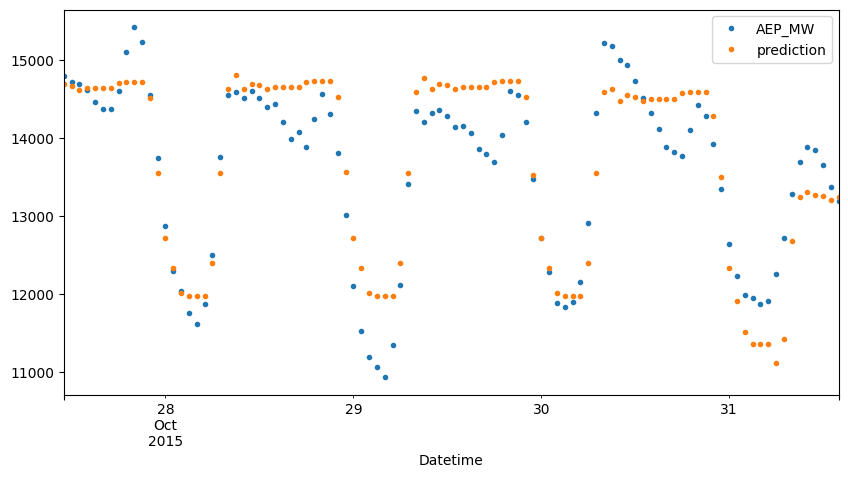

In [21]:
test_predic.plot(y=['AEP_MW','prediction'], style='.',figsize=(10,5))

##### Calcul de l'erreur (root_mean_squared_error) entre les prédictions et les données réelles brutes du set "**Test**".

In [25]:
score = mean_squared_error(test['AEP_MW'], test['prediction'], squared=False)
print('RMSE =', score)

RMSE = 1616.5457531791394
